   Copyright 2019 Benjamin Santos

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.


If you find this notebook useful, please cite as: Santos, B., Cacot, L., Boucher, C. & Vidal, F. Electrostatic enhancement factor for the coagulation of silicon nanoparticles in low-temperature plasmas. Plasma Sources Sci. Technol. 28, 045002 (2019).

```@article{santos_electrostatic_2019,
	title = {Electrostatic enhancement factor for the coagulation of silicon nanoparticles in low-temperature plasmas},
	volume = {28},
	issn = {0963-0252},
	url = {https://doi.org/10.1088%2F1361-6595%2Fab0a2b},
	doi = {10.1088/1361-6595/ab0a2b},
	number = {4},
	urldate = {2019-06-01},
	journal = {Plasma Sources Sci. Technol.},
	author = {Santos, Benjamin and Cacot, Laura and Boucher, Claude and Vidal, François},
	month = apr,
	year = {2019},
	pages = {045002},
}```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('../')

In [3]:
import numpy as np
import scipy.constants as const

In [4]:
import grodi as gro
import trazar as tzr
import coagulatio as coag
import plazma as pz
import carrus as car

In [5]:
import charging as chrng

In [6]:
def run(tf, dt, gridfile, defpath='data/'):

    grid_data = gro.GridData(gridfile, defpath)

    grid_data.set_rates()

    coag.birthlist_toarrays(grid_data.birth_list,
                            grid_data.birth_larray, grid_data.birth_qarray,
                            grid_data.birth_marray, grid_data.birth_parray,
                            grid_data.birth_narray, grid_data.birth_rarray,
                            grid_data.birth_array)

    coag.deathlist_toarrays(grid_data.death_list,
                            grid_data.death_larray, grid_data.death_qarray,
                            grid_data.death_marray, grid_data.death_parray,
                            grid_data.death_array)

    grid_data.free_lists()

    surface_growth = gro.SurfaceGrowth(grid_data)

    surface_growth.compute_adim_srate()

    nucleation = gro.Nucleation(grid_data)

    nucleation.compute_nucleation()

    growth_data = gro.GrowthData(grid_data, delta_t=dt, end_time=tf, n0=1e10)

    growth_data.jnucleation = nucleation.jnucleation

    rates_dict = dict()

    rates_dict["R1:kel"] = ("a1expb", 1.8560282921521678e-13, 0.1633129254054345, 0.0)
    rates_dict["R2:ki"] = ("arrhenius", 7.41485579e-14, 15.8, 5.00954185e-3)
    rates_dict["R3:kex"] = ("arrhenius", 3.364506180166679e-14, 11.5, 3.7596917572476254e-09)
    rates_dict["R4:kiarm"] = ("arrhenius", 1.911868293754553e-13, 4.2, 2.6193020484482345e-09)
    rates_dict["R5:kelsih4"] = ("a1expb", 2.663032076381496e-13, 0.27729017757606, 0.0)
    rates_dict["R6:kdisih4"] = ("arrhenius", 3.6864532111053647e-14, 12.3, 7.585426699230944e-09)
    rates_dict["R7:kdsih3"] = ("arrhenius", 1.060628946494521e-13, 8.4, 0.07797295284736888)
    rates_dict["R8:kdsih2"] = ("arrhenius", 8.999280746645033e-14, 7.7, 9.918880635931725e-10)
    rates_dict["R9:kisih3"] = ("arrhenius", 4.6999933119522564e-14, 8.0, 0.1625740097963909)
    rates_dict["R10:kv13"] = ("arrhenius",  5.2570315025458126e-15, 0.27, 7.675878736753314e-09)
    rates_dict["R11:kv24"] = ("arrhenius", 9.646752429918597e-15, 0.113, 1.5565618639018595e-08)
    rates_dict["R12:k12"] = ("constant", 1.4e-16, 0.0, 0.0)
    rates_dict["R13:k13"] = ("constant", 2.59e-16, 0.0, 0.0)
    rates_dict["R14:k14"] = ("constant", 9.96e-17, 0.0, 0.0)
    rates_dict["R15:k15"] = ("constant", 9.96e-17, 0.0,0.0)

    rmap = pz.RatesMap(rates_dict)

    rates_map = rmap.get_ratesmap()

    plasmasystem = pz.PlasmaSystem(4e-2,
                                   6e-2,
                                   300.0,
                                   300.0,
                                   0.1,
                                   29.0/30.0,
                                   6.6335209e-26,
                                   5.3150534e-26,
                                   1./const.elementary_charge,
                                   1.0)

    print(plasmasystem)

    pc = pz.PlasmaChem(rates_map, plasmasystem)
    sys = pc.get_system()

    nvols = grid_data.nvols
    nchrgs = grid_data.nchrgs

    cf = car.CollisionFrequency(plasmasystem, grid_data)

    charging = car.Charging(cf, grid_data)

    for i, t in enumerate(np.arange(0, 10e-3, 1e-6)):
        car.compute_plasmacharging(t, 1e-6, grid_data, pc, growth_data, charging, plasmasystem)
        pc.past_plasmadensity = pc.next_plasmadensity

    plasma_history = np.zeros((7, len(growth_data.time)))

    dt = growth_data.delta_t
    for i, t in enumerate(growth_data.time):

        # compute plasma and charging in time t -> t+dt/2
        car.compute_plasmacharging(t, 0.5*dt, grid_data, pc,
                                   growth_data, charging, plasmasystem)
        # update plasma densities
        pc.past_plasmadensity = pc.next_plasmadensity
        # compute charging
        chrng.charging_totalstep(t, 0.5*dt, grid_data, pc,
                                 growth_data, charging, plasmasystem)
        # update nanoparticle density
        growth_data.past_density[:] = growth_data.next_density[:]
        # nano growth
        gro.nanoparticle_growth(growth_data, grid_data, surface_growth)
        # compute plasma and charging in time t+dt/2 -> t+dt   
        car.compute_plasmacharging(t+0.5*dt, 0.5*dt, grid_data,
                                   pc, growth_data, charging, plasmasystem)        
        # update plasma densities
        pc.past_plasmadensity = pc.next_plasmadensity
        # compute charging
        chrng.charging_totalstep(t+0.5*dt, 0.5*dt, grid_data,
                                 pc, growth_data, charging, plasmasystem)
        # update nanoparticle density
        growth_data.past_density[:] = growth_data.next_density[:]
        # update plasma history
        plasma_history[:, i] = pc.next_plasmadensity
        growth_data.update_results(i)
    grid_data.close()
    
    return grid_data, growth_data, plasma_history

In [7]:
gridfile = 'grid-mpcvdw-sym-100x60-rc21'
tf = 1.0
dt = 1e-3

In [8]:
%%time
grid_data, growth_data, plasma_history = run(tf, dt, gridfile)

System(length=0.04, radius=0.06, temperature=300.0, ion_temperature=300.0, pressure_torr=0.1, arsih4_ratio=0.9666666666666667, armass=6.6335209e-26, sih4mass=5.3150534e-26, power=6.241509125883258e+18, with_tunnel=1.0)
CPU times: user 20min 28s, sys: 4.7 s, total: 20min 33s
Wall time: 9min 18s


In [9]:
growth_data.post_processing()

In [10]:
nano_data = gro.NanoData('nanoparticle-plasma-test', defpath= 'data/')

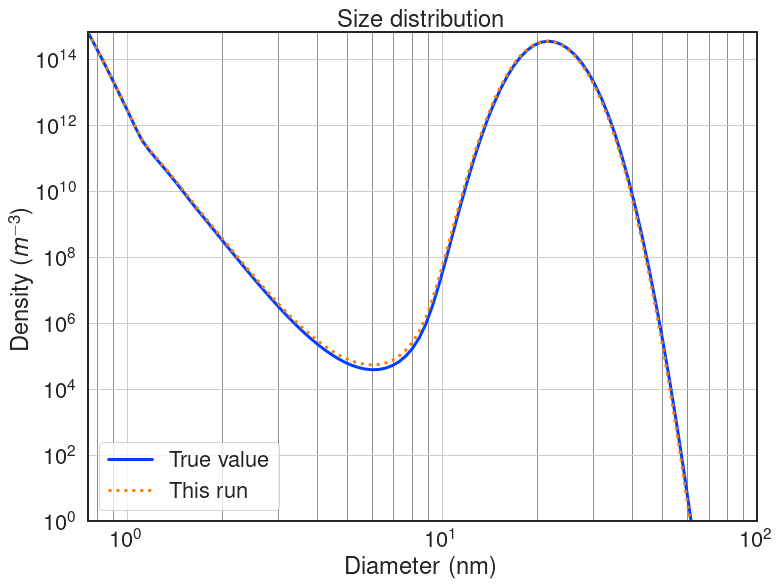

In [11]:
tzr.plot_distro(grid_data.dpivots, [nano_data.ddens,
                                    growth_data.ddens[-1]],
                labels=["True value", "This run"],
                linestyles=['-', ':'],
                savename="test/nanoparticle-plasma-test-sizedist.png")

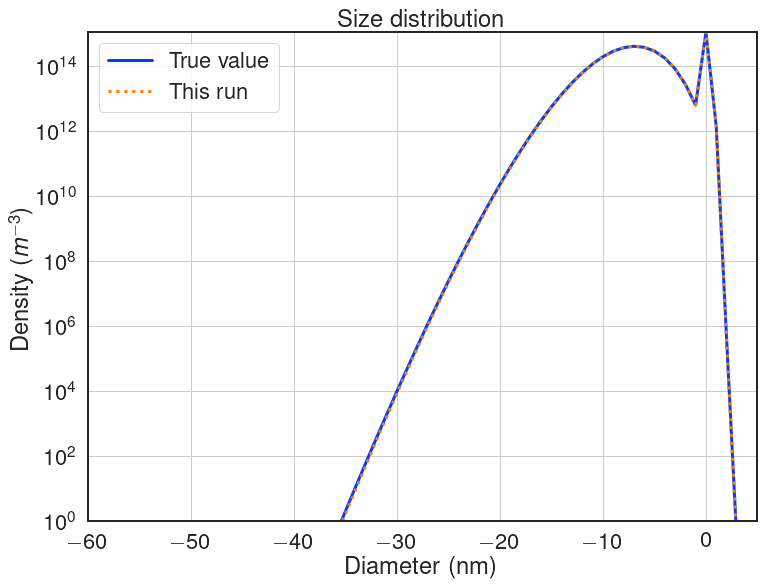

In [12]:
tzr.plot_distro(grid_data.qpivots, [nano_data.cdens, growth_data.cdens[-1]],
               labels=["True value", "This run"], linestyles=['-', ':'], logx=False,
               savename="test/nanoparticle-plasma-test-chargedist.png")

In [13]:
xlabel = "Time (s)"
ylabel = r'Density (m$^{-3}$)'
labels = ['e', r'Ar$^+$', r'Ar$^*$', r'SiH$^+_3$', r'SiH$_3$', r'SiH$_2$', r'N$_Q$']
densities = [plasma_history[i, ::10] for i in range(6)]
densities.append(-growth_data.total_charge)

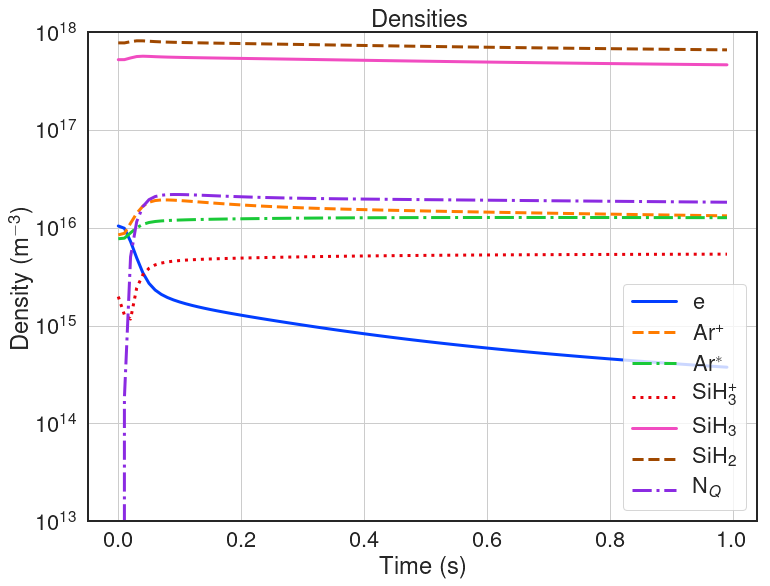

In [14]:
tzr.plot_plain(growth_data.stime, densities, title="Densities",
               axislabel=[xlabel, ylabel],
               logx=False, logy=True, labels=labels, ylim=[1e13, 1e18],
               savename="test/nanoparticle-plasma-test-plasma.png")

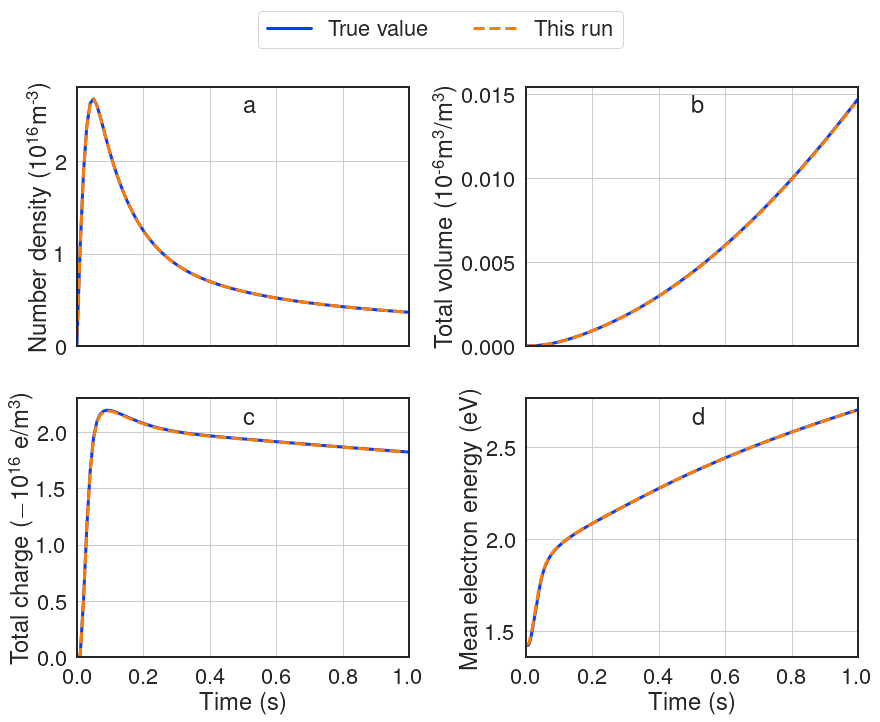

In [15]:
dirprefix = "data/"

momentlist = ["nanoparticle-plasma-test-moments.dat"]

mlist = [dirprefix+f for f in momentlist]

plasmalist = ["nanoparticle-plasma-test-plasma.dat"]

plist = [dirprefix+f for f in plasmalist]

labels = ['True value', 'This run']

filename = "nanoparticle-plasma-test-panels.png"

panels = tzr.PlotPanels(mlist, plist, labels, filename, coagulation_alone=False)

moments = np.array([growth_data.stime, growth_data.total_number, growth_data.total_volume, growth_data.total_charge]).T

panels.moments.append(moments)

pdensities = np.array([growth_data.stime, (plasma_history[6, ::10]/densities[0])]).T

panels.plasma.append(pdensities)

pmom = panels.plot()

In [16]:
nano_data.close()